TJ Wiegman  
ASM 591 AI  
Lab 6  
2024-10-23

# **Comparison of SARSA, QL, and DQN**

**Environment Implementation**

OpenAI Gym provides the Taxi environment out of the box. Here's how to initialize and interact with it:

In [1]:
import gym
import numpy as np

# Initialize the Taxi environment
env = gym.make("Taxi-v3", render_mode="ansi").env

# Reset the environment to start
state = env.reset()

# Render the initial state
env.render()

# Sample random action
action = env.action_space.sample()
next_state, reward, done, trunc, info = env.step(action)

print(f"Action Taken: {action}")
print(f"Next State: {next_state}")
print(f"Reward: {reward}")
print(f"Done: {done}")

# Render the next state
env.render()


Action Taken: 0
Next State: 134
Reward: -1
Done: False


/home/tjw/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


'+---------+\n|R: | : :G|\n| :\x1b \x1b| : : |\n| : : : : |\n| | : | : |\n|\x1bY\x1b| : |\x1bB\x1b: |\n+---------+\n  (South)\n'

**Understanding the State Space**

The state in Taxi-v3 is encoded as a single integer representing the taxi's position, passenger location, and destination. To interpret it, you can use the following helper functions:

In [2]:
import math

def decode_state(state):
    """
    Decode the state into taxi row, taxi column, passenger location, and destination.
    """
    out = []
    out.append(state % 4)
    state = math.floor(state / 4)
    out.append(state % 5)
    state = math.floor(state / 5)
    out.append(state % 5)
    out.append(math.floor(state / 5))
    return out

# Example:
decoded = decode_state(next_state)
print(f"Decoded State: {decoded}")
# Output: [passenger_location, taxi_row, taxi_col, destination]


Decoded State: [2, 3, 1, 1]


## SARSA

SARSA is an on-policy algorithm, meaning it updates the Q-values based on the action actually taken by the current policy.

In [3]:
import numpy as np
import random
import gym

class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

    def choose_action(self, state):
        if random.uniform(0,1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def learn(self, episodes=500):
        steps_per_episode = []
        rewards_per_episode = []
        for episode in range(episodes):
            state = self.env.reset()[0]
            action = self.choose_action(state)
            done = False
            total_reward = 0
            steps = 0
            while not done:
                next_state, reward, done, trunc, info = self.env.step(action)
                next_action = self.choose_action(next_state)
                # SARSA update
                td_target = reward + self.gamma * self.Q[next_state, next_action] if not done else reward
                td_error = td_target - self.Q[state, action]
                self.Q[state, action] += self.alpha * td_error
                state = next_state
                action = next_action
                total_reward += reward
                steps += 1
            steps_per_episode.append(steps)
            rewards_per_episode.append(total_reward)
            if (episode+1) % 100 == 0:
                print(f"SARSA Agent - Episode {episode+1}/{episodes}")
        return steps_per_episode, rewards_per_episode


**Training the SARSA Agent**

In [4]:
# Initialize SARSA Agent
sarsa_agent = SARSAAgent(env)

# Train the agent
sarsa_steps, sarsa_rewards = sarsa_agent.learn(episodes=1000)

# Display learned Q-values for a specific state
state = 328  # Example state
print(f"SARSA Q-values for state {state}: {sarsa_agent.Q[state]}")


SARSA Agent - Episode 100/1000
SARSA Agent - Episode 200/1000
SARSA Agent - Episode 300/1000
SARSA Agent - Episode 400/1000
SARSA Agent - Episode 500/1000
SARSA Agent - Episode 600/1000
SARSA Agent - Episode 700/1000
SARSA Agent - Episode 800/1000
SARSA Agent - Episode 900/1000
SARSA Agent - Episode 1000/1000
SARSA Q-values for state 328: [-4.64102594 -4.55778995 -4.7287415  -4.68725936 -5.57812247 -5.55504272]


**Visualizing the Policy**

In [5]:
def plot_policy_sarsa(agent, env):
    policy = np.argmax(agent.Q, axis=1)
    env.reset()
    env.render()
    for state in range(env.observation_space.n):
        decoded = decode_state(state)
        print(f"State {state}: Action {policy[state]}")

print("SARSA Learned Policy:")
plot_policy_sarsa(sarsa_agent, env)


SARSA Learned Policy:
State 0: Action 0
State 1: Action 4
State 2: Action 4
State 3: Action 4
State 4: Action 0
State 5: Action 0
State 6: Action 2
State 7: Action 2
State 8: Action 0
State 9: Action 3
State 10: Action 0
State 11: Action 1
State 12: Action 0
State 13: Action 1
State 14: Action 1
State 15: Action 0
State 16: Action 5
State 17: Action 0
State 18: Action 0
State 19: Action 2
State 20: Action 0
State 21: Action 3
State 22: Action 3
State 23: Action 3
State 24: Action 3
State 25: Action 0
State 26: Action 3
State 27: Action 1
State 28: Action 1
State 29: Action 0
State 30: Action 0
State 31: Action 3
State 32: Action 1
State 33: Action 1
State 34: Action 0
State 35: Action 0
State 36: Action 3
State 37: Action 0
State 38: Action 0
State 39: Action 0
State 40: Action 0
State 41: Action 2
State 42: Action 1
State 43: Action 2
State 44: Action 0
State 45: Action 0
State 46: Action 2
State 47: Action 2
State 48: Action 4
State 49: Action 2
State 50: Action 0
State 51: Action 0


## Q-Learning

Q-Learning is an off-policy algorithm, meaning it learns the value of the optimal policy regardless of the agent's actions.

In [6]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

    def choose_action(self, state):
        if random.uniform(0,1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def learn(self, episodes=500):
        steps_per_episode = []
        rewards_per_episode = []
        for episode in range(episodes):
            state = self.env.reset()[0]
            done = False
            total_reward = 0
            steps = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, trunc, info = self.env.step(action)
                # Q-Learning update
                best_next_action = np.argmax(self.Q[next_state])
                td_target = reward + self.gamma * self.Q[next_state, best_next_action] if not done else reward
                td_error = td_target - self.Q[state, action]
                self.Q[state, action] += self.alpha * td_error
                state = next_state
                total_reward += reward
                steps += 1
            steps_per_episode.append(steps)
            rewards_per_episode.append(total_reward)
            if (episode+1) % 100 == 0:
                print(f"Q-Learning Agent - Episode {episode+1}/{episodes}")
        return steps_per_episode, rewards_per_episode


In [7]:
# Initialize Q-Learning Agent
q_learning_agent = QLearningAgent(env)

# Train the agent
q_steps, q_rewards = q_learning_agent.learn(episodes=1000)

# Display learned Q-values for a specific state
state = 328  # Example state
print(f"Q-Learning Q-values for state {state}: {q_learning_agent.Q[state]}")


Q-Learning Agent - Episode 100/1000
Q-Learning Agent - Episode 200/1000
Q-Learning Agent - Episode 300/1000
Q-Learning Agent - Episode 400/1000
Q-Learning Agent - Episode 500/1000
Q-Learning Agent - Episode 600/1000
Q-Learning Agent - Episode 700/1000
Q-Learning Agent - Episode 800/1000
Q-Learning Agent - Episode 900/1000
Q-Learning Agent - Episode 1000/1000
Q-Learning Q-values for state 328: [-4.10715308 -1.60336947 -4.07824872 -4.11008712 -4.6887158  -4.90117703]


In [8]:
def plot_policy_q_learning(agent, env):
    policy = np.argmax(agent.Q, axis=1)
    env.reset()
    env.render()
    for state in range(env.observation_space.n):
        decoded = decode_state(state)
        print(f"State {state}: Action {policy[state]}")

print("Q-Learning Learned Policy:")
plot_policy_q_learning(q_learning_agent, env)


Q-Learning Learned Policy:
State 0: Action 0
State 1: Action 4
State 2: Action 4
State 3: Action 4
State 4: Action 0
State 5: Action 0
State 6: Action 3
State 7: Action 2
State 8: Action 0
State 9: Action 1
State 10: Action 0
State 11: Action 0
State 12: Action 0
State 13: Action 1
State 14: Action 1
State 15: Action 0
State 16: Action 5
State 17: Action 0
State 18: Action 0
State 19: Action 0
State 20: Action 0
State 21: Action 3
State 22: Action 3
State 23: Action 3
State 24: Action 2
State 25: Action 0
State 26: Action 1
State 27: Action 1
State 28: Action 1
State 29: Action 3
State 30: Action 0
State 31: Action 2
State 32: Action 2
State 33: Action 2
State 34: Action 3
State 35: Action 0
State 36: Action 3
State 37: Action 0
State 38: Action 3
State 39: Action 0
State 40: Action 0
State 41: Action 1
State 42: Action 2
State 43: Action 1
State 44: Action 2
State 45: Action 0
State 46: Action 2
State 47: Action 2
State 48: Action 0
State 49: Action 3
State 50: Action 0
State 51: Acti

## Deep Q-Learning

Deep Q-Learning leverages neural networks to approximate the Q-values, allowing the agent to handle larger and more complex state spaces.

In [14]:
# wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
# sudo dpkg -i cuda-keyring_1.1-1_all.deb
# sudo apt update && sudo apt install cuda-toolkit-12-4
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# pip3 install gym pygame matplotlib numpy


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.01, batch_size=64, memory_size=10000):
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(self.state_size, self.action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
        self.criterion = nn.MSELoss()

    def one_hot_encode(self, state):
        state_vec = np.zeros(self.state_size)
        # if type(state) != int:
        #     print(f"WARNING: {state} is not INT, is {type(state)}")
        state_vec[state] = 1
        return state_vec

    def choose_action(self, state):
        if random.uniform(0,1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            state_vec = self.one_hot_encode(state)
            state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values[0]).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)

        states = []
        targets = []

        for state, action, reward, next_state, done in minibatch:
            state_vec = self.one_hot_encode(state)
            next_state_vec = self.one_hot_encode(next_state)
            target = reward
            if not done:
                with torch.no_grad():
                    next_q = self.model(torch.FloatTensor(next_state_vec).unsqueeze(0).to(self.device))
                    target += self.gamma * torch.max(next_q[0]).item()
            target_f = self.model(torch.FloatTensor(state_vec).unsqueeze(0).to(self.device))
            target_f = target_f.cpu().detach().numpy()
            target_f[0][action] = target
            states.append(state_vec)
            targets.append(target_f[0])

        states = torch.FloatTensor(states).to(self.device)
        targets = torch.FloatTensor(targets).to(self.device)

        outputs = self.model(states)
        loss = self.criterion(outputs, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes=10):
        steps_per_episode = []
        rewards_per_episode = []
        for episode in range(1, episodes+1):
            state = self.env.reset()[0]
            done = False
            total_reward = 0
            steps = 0
            bail = False
            while not (done or bail):
                print(f"[{episode}/{episodes}] Step {steps}", end="")
                action = self.choose_action(state)
                next_state, reward, done, trunc, info = self.env.step(action)
                self.remember(state, action, reward, next_state, done)
                self.replay()
                state = next_state
                total_reward += reward
                steps += 1
                print("\r                                  ", end="\r")
                bail = (steps >= 16000)
            if not bail:
                print(f"[{episode}/{episodes}] Trained in {steps} steps")
                steps_per_episode.append(steps)
                rewards_per_episode.append(total_reward)
                if episode % 100 == 0:
                    print(f"DQN Agent - Episode {episode}/{episodes}, Epsilon: {self.epsilon:.2f}")
            else:
                print(f"[{episode}/{episodes}] Failed to train in {steps} steps, skipping")
        return steps_per_episode, rewards_per_episode

    def get_policy(self):
        policy = []
        for state in range(self.env.observation_space.n):
            state_vec = self.one_hot_encode(state)
            state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            action = torch.argmax(q_values[0]).item()
            policy.append(action)
        return policy


In [44]:
# Initialize DQN Agent
dqn_agent = DQNAgent(env)

# Train the agent
dqn_steps, dqn_rewards = dqn_agent.learn(episodes=10)

# Display learned policy
def plot_policy_dqn(agent, env):
    policy = agent.get_policy()
    for state in range(env.observation_space.n):
        decoded = decode_state(state)
        print(f"State {state}: Action {policy[state]}")

print("Deep Q-Learning Learned Policy:")
plot_policy_dqn(dqn_agent, env)


[1/10] Failed to train in 16000 steps, skipping
[2/10] Failed to train in 16000 steps, skipping
[3/10] Failed to train in 16000 steps, skipping
[4/10] Failed to train in 16000 steps, skipping
[5/10] Failed to train in 16000 steps, skipping
[6/10] Failed to train in 16000 steps, skipping
[7/10] Failed to train in 16000 steps, skipping
[8/10] Failed to train in 16000 steps, skipping
[9/10] Failed to train in 16000 steps, skipping
[10/10] Failed to train in 16000 steps, skipping
Deep Q-Learning Learned Policy:
State 0: Action 1
State 1: Action 4
State 2: Action 1
State 3: Action 1
State 4: Action 1
State 5: Action 1
State 6: Action 1
State 7: Action 1
State 8: Action 1
State 9: Action 1
State 10: Action 1
State 11: Action 1
State 12: Action 1
State 13: Action 1
State 14: Action 1
State 15: Action 1
State 16: Action 1
State 17: Action 5
State 18: Action 1
State 19: Action 1
State 20: Action 1
State 21: Action 1
State 22: Action 1
State 23: Action 3
State 24: Action 1
State 25: Action 1
Sta

**Comparing the Algorithms**

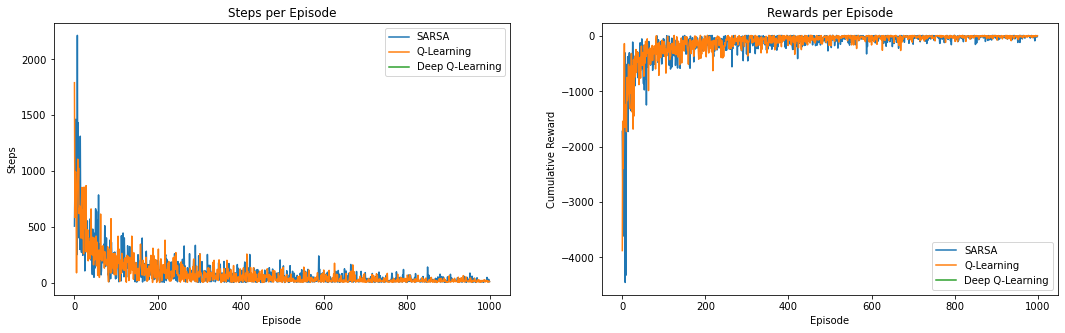

In [45]:
import matplotlib.pyplot as plt

def plot_performance(sarsa_steps, sarsa_rewards, q_steps, q_rewards, dqn_steps, dqn_rewards):
    plt.figure(figsize=(18,5))

    # Steps per Episode
    plt.subplot(1,2,1)
    plt.plot(sarsa_steps, label='SARSA')
    plt.plot(q_steps, label='Q-Learning')
    plt.plot(dqn_steps, label='Deep Q-Learning')
    plt.title('Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.legend()

    # Rewards per Episode
    plt.subplot(1,2,2)
    plt.plot(sarsa_rewards, label='SARSA')
    plt.plot(q_rewards, label='Q-Learning')
    plt.plot(dqn_rewards, label='Deep Q-Learning')
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()

    plt.show()

# Assuming sarsa_steps, sarsa_rewards, q_steps, q_rewards, dqn_steps, dqn_rewards are obtained from training
plot_performance(sarsa_steps, sarsa_rewards, q_steps, q_rewards, dqn_steps, dqn_rewards)

# **Problem**

# **Problem Statement: Optimal Irrigation Scheduling**
## Overview

Efficient water management is crucial in agriculture to ensure optimal crop growth while conserving water resources. The goal is to determine the optimal irrigation schedule that maximizes crop yield and minimizes water usage. This problem involves deciding how much water to apply to the crops at different times based on various environmental factors.
Environment Specifications

    Objective: Maximize crop yield while minimizing water usage.
    Crop: Assume a single type of crop with specific water needs.
    Time Frame: Daily irrigation decisions over a growing season (e.g., 100 days).
    State Variables:
        Soil Moisture Level: Current moisture content in the soil (range: 0 to 100 units).
        Weather Forecast:
            Rainfall Prediction: Probability of rainfall the next day (0% to 100%).
            Temperature: Expected temperature for the next day (°C).
    Actions:
        Irrigation Amount: Discrete choices (e.g., 0, 10, 20, 30 liters per square meter).
    Rewards:
        Positive Reward: For maintaining soil moisture within the optimal range for crop growth.
        Negative Reward: For over-irrigation (wasted water) or under-irrigation (reduced yield).
        Water Usage Penalty: To discourage excessive water use.

##Detailed Specifications

    State Representation:
        Soil Moisture (S_m): Integer value between 0 and 100.
        Rainfall Probability (S_r): Integer percentage between 0 and 100.
        Temperature (S_t): Integer value between 15°C and 35°C.

    The state can be represented as a tuple: (S_m, S_r, S_t).

    Action Space (A):
        0: No irrigation.
        10: Apply 10 liters/m².
        20: Apply 20 liters/m².
        30: Apply 30 liters/m².

    Transition Dynamics:

        Soil Moisture Update:
        Sm(t+1)=Sm(t)+Irrigation Amount+Rainfall Contribution−Evapotranspiration
        Sm(t+1)​=Sm(t)​+Irrigation Amount+Rainfall Contribution−Evapotranspiration
            Rainfall Contribution: If rainfall occurs, add moisture based on probability.
            Evapotranspiration: Depends on temperature; higher temperatures lead to more moisture loss.

        Rainfall Occurrence:
            Based on S_r, simulate whether it rains the next day.
            If it rains, add a random moisture contribution (e.g., 5-15 units).

        Evapotranspiration Calculation:
            Use a simple linear model:
            Evapotranspiration=k×(St−15)
            Evapotranspiration=k×(St​−15) where kk is a constant (e.g., 2).

        Constraints:
            Soil moisture cannot exceed 100 or drop below 0.

    Reward Function (R):
        Optimal Moisture Range: 40 ≤ S_m ≤ 60.
            Reward: +10 for each day within this range.
        Under-Irrigation: S_m < 40.
            Penalty: -10 per day.
        Over-Irrigation: S_m > 60.
            Penalty: -5 per day.
        Water Usage: Subtract a small penalty proportional to the irrigation amount to encourage water conservation.
        R=Yield Reward/Penalty−0.1×Irrigation Amount
        R=Yield Reward/Penalty−0.1×Irrigation Amount

    Episode Termination:
        After 100 days or if the soil moisture drops below a critical level (e.g., 0).

##Visualization

Since the environment is non-spatial, visualization focuses on tracking soil moisture, weather conditions, and irrigation actions over time. Plots can include:

    Soil Moisture Over Time: Line graph showing daily moisture levels.
    Irrigation Actions: Bar graph indicating irrigation amounts applied each day.
    Weather Conditions: Overlay rainfall occurrences and temperature changes.

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

class IrrigationEnv:

    def __init__(self, episodes=100):

        class ObservationSpace(dict):
            def __init__(self, data):
                super().__init__()
                for key, value in data.items():
                    self[key] = value

            @property
            def observation_space(self):
                return dict(self)
            
            @property
            def n(self):
                return len(self.observation_space)
            
        class ActionSpace:
            def __init__(self, data):
                self._space = data

            @property
            def action_space(self):
                return self._space

            @property
            def n(self):
                return len(self.action_space)
            
            def sample(self):
                return random.choice(range(self.n))

        self.max_moisture = 100
        self.min_moisture = 0
        self.optimal_min = 40
        self.optimal_max = 60
        self.evapotranspiration_coefficient = 2  # k in evapotranspiration formula
        self.episodes = episodes

        obs = {}
        i = 0
        for m in range(self.min_moisture, self.max_moisture+1):
            for r in range(0,100+1): # rainfall
                for t in range(15, 35+1): # temperature
                    obs[(m,r,t)] = [i]
                    i += 1
        self.observation_space = ObservationSpace(obs)
        self.action_space = ActionSpace([0, 10, 20, 30])
        self.reset()

    def reset(self):
        self.soil_moisture = random.randint(40, 60)  # Start within optimal range
        self.rainfall_prob = random.randint(0, 100)
        self.temperature = random.randint(15, 35)
        self.day = 0
        self.total_reward = 0
        return self._get_state()

    def _get_state(self):
        return self.observation_space[(self.soil_moisture, self.rainfall_prob, self.temperature)]

    def step(self, action):
        """
        Action: irrigation amount (0, 10, 20, 30 liters/m²)
        """
        irrigation = action  # Assuming action directly maps to irrigation amount
        # Apply irrigation
        self.soil_moisture += irrigation

        # Simulate rainfall
        rain_occurs = random.uniform(0, 100) < self.rainfall_prob
        rain_contribution = random.randint(5, 15) if rain_occurs else 0
        self.soil_moisture += rain_contribution

        # Simulate evapotranspiration
        evapotranspiration = self.evapotranspiration_coefficient * (self.temperature - 15)
        self.soil_moisture -= evapotranspiration

        # Update soil moisture constraints
        self.soil_moisture = min(max(self.soil_moisture, self.min_moisture), self.max_moisture)

        # Calculate reward
        if self.optimal_min <= self.soil_moisture <= self.optimal_max:
            reward = 10
        elif self.soil_moisture < self.optimal_min:
            reward = -10
        else:  # self.soil_moisture > self.optimal_max
            reward = -5
        # Subtract water usage penalty
        reward -= 0.1 * irrigation

        # Advance to next day
        self.day += 1

        # Update weather for next day
        self.rainfall_prob = random.randint(0, 100)  # New rainfall probability
        self.temperature = random.randint(15, 35)  # New temperature

        # Check termination
        done = False
        if self.day >= self.episodes or self.soil_moisture <= 0:
            done = True

        self.total_reward += reward
        return self._get_state(), reward, done, {}, {}

    def render(self):
        print(f"Day: {self.day}")
        print(f"Soil Moisture: {self.soil_moisture}")
        print(f"Rainfall Probability: {self.rainfall_prob}%")
        print(f"Temperature: {self.temperature}°C")
        print(f"Total Reward: {self.total_reward}\n")

    def plot_metrics(self, rewards, irrigation_actions, soil_moistures):
        days = range(1, len(rewards)+1)

        plt.figure(figsize=(15, 5))

        # Soil Moisture
        plt.subplot(1, 3, 1)
        plt.plot(days, soil_moistures, label='Soil Moisture')
        plt.axhline(self.optimal_min, color='green', linestyle='--', label='Optimal Range')
        plt.axhline(self.optimal_max, color='green', linestyle='--')
        plt.xlabel('Day')
        plt.ylabel('Soil Moisture')
        plt.title('Soil Moisture Over Time')
        plt.legend()

        # Irrigation Actions
        plt.subplot(1, 3, 2)
        plt.bar(days, irrigation_actions, color='blue')
        plt.xlabel('Day')
        plt.ylabel('Irrigation Amount (liters/m²)')
        plt.title('Irrigation Actions Over Time')

        # Rewards
        plt.subplot(1, 3, 3)
        plt.plot(days, rewards, label='Daily Reward', color='red')
        plt.xlabel('Day')
        plt.ylabel('Reward')
        plt.title('Daily Rewards Over Time')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [11]:
# Initialize the environment
env = IrrigationEnv(episodes=10)

# Reset the environment to start
state = env.reset()

# Render the initial state
env.render()

# Take random actions for 10 days
for _ in range(10):
    action = random.choice([0, 10, 20, 30])
    next_state, reward, done, _, _ = env.step(action)
    print(f"Action Taken: {action} liters/m², Reward: {reward}")
    env.render()
    if done:
        break


Day: 0
Soil Moisture: 48
Rainfall Probability: 35%
Temperature: 25°C
Total Reward: 0

Action Taken: 20 liters/m², Reward: 8.0
Day: 1
Soil Moisture: 48
Rainfall Probability: 4%
Temperature: 17°C
Total Reward: 8.0

Action Taken: 30 liters/m², Reward: -8.0
Day: 2
Soil Moisture: 74
Rainfall Probability: 56%
Temperature: 28°C
Total Reward: 0.0

Action Taken: 10 liters/m², Reward: -6.0
Day: 3
Soil Moisture: 65
Rainfall Probability: 65%
Temperature: 35°C
Total Reward: -6.0

Action Taken: 30 liters/m², Reward: 7.0
Day: 4
Soil Moisture: 55
Rainfall Probability: 45%
Temperature: 20°C
Total Reward: 1.0

Action Taken: 0 liters/m², Reward: 10.0
Day: 5
Soil Moisture: 59
Rainfall Probability: 40%
Temperature: 26°C
Total Reward: 11.0

Action Taken: 20 liters/m², Reward: 8.0
Day: 6
Soil Moisture: 57
Rainfall Probability: 21%
Temperature: 19°C
Total Reward: 19.0

Action Taken: 30 liters/m², Reward: -8.0
Day: 7
Soil Moisture: 79
Rainfall Probability: 13%
Temperature: 30°C
Total Reward: 11.0

Action Taken

## Exercise: Implement SARSA, Q-L, and DQN
### SARSA

In [12]:
irrigation_sarsa = SARSAAgent(env)
sarsa_steps, sarsa_rewards = irrigation_sarsa.learn(episodes=1000)

SARSA Agent - Episode 100/1000
SARSA Agent - Episode 200/1000
SARSA Agent - Episode 300/1000
SARSA Agent - Episode 400/1000
SARSA Agent - Episode 500/1000
SARSA Agent - Episode 600/1000
SARSA Agent - Episode 700/1000
SARSA Agent - Episode 800/1000
SARSA Agent - Episode 900/1000
SARSA Agent - Episode 1000/1000


### Q-Learning

In [13]:
irrigation_ql = QLearningAgent(env)
ql_steps, ql_rewards = irrigation_ql.learn(episodes=1000)

Q-Learning Agent - Episode 100/1000
Q-Learning Agent - Episode 200/1000
Q-Learning Agent - Episode 300/1000
Q-Learning Agent - Episode 400/1000
Q-Learning Agent - Episode 500/1000
Q-Learning Agent - Episode 600/1000
Q-Learning Agent - Episode 700/1000
Q-Learning Agent - Episode 800/1000
Q-Learning Agent - Episode 900/1000
Q-Learning Agent - Episode 1000/1000


### Deep Q-Learning

In [15]:
irrigation_dqn = DQNAgent(env)
dqn_steps, dqn_rewards = irrigation_dqn.learn(episodes=20)

[1/20] Trained in 4 steps         
[2/20] Trained in 3 steps         
[3/20] Trained in 3 steps         
[4/20] Trained in 7 steps         
[5/20] Trained in 4 steps         
[6/20] Trained in 4 steps         
[7/20] Trained in 7 steps         
[8/20] Trained in 3 steps         
[9/20] Trained in 3 steps         
[10/20] Trained in 4 steps        
[11/20] Trained in 4 steps        
[12/20] Trained in 3 steps        
[13/20] Trained in 2 steps        
[14/20] Trained in 3 steps        
[15/20] Trained in 7 steps        
[16/20] Trained in 2 steps        
[17/20] Trained in 5 steps        
[18/20] Trained in 3 steps        
[19/20] Trained in 7 steps        
[20/20] Trained in 5 steps        


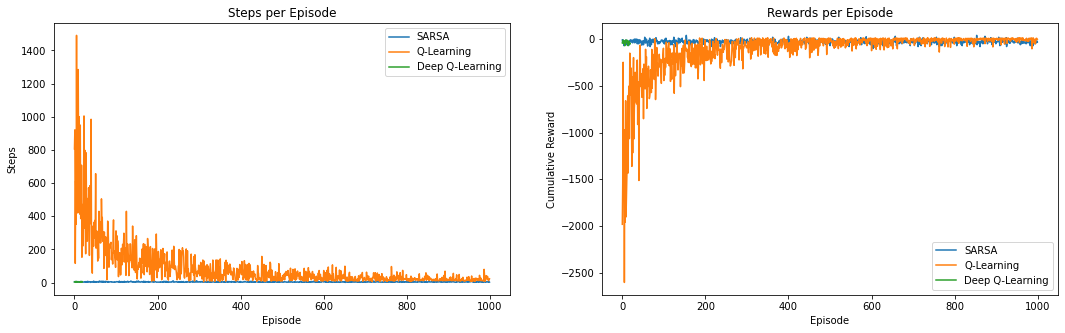

In [18]:
plot_performance(sarsa_steps, sarsa_rewards, q_steps, q_rewards, dqn_steps, dqn_rewards)

# **Problem 2: Optimal Stock Trading**

## Overview

Efficient stock trading is crucial in finance to maximize returns while managing risks. The goal is to determine the optimal trading strategy that decides when to buy, sell, or hold a stock to maximize cumulative profits. This problem involves making sequential trading decisions based on market data and other relevant factors.
##Environment Specifications

    Objective: Maximize cumulative profit from trading a single stock over a period.
    Time Frame: Daily trading decisions over a year (e.g., 252 trading days).
    State Variables:
        Current Price: The stock's closing price for the current day.
        Moving Averages:
            Short-Term (e.g., 5-day)
            Long-Term (e.g., 20-day)
        Price Momentum: Difference between short-term and long-term moving averages.
        Volatility: Standard deviation of stock returns over a window (e.g., 10 days).
    Actions:
        0: Hold (no action).
        1: Buy one unit of the stock.
        2: Sell one unit of the stock.
    Rewards:
        Profit: Positive reward equal to the profit made from selling the stock.
        Penalty: Negative reward for holding positions overnight with significant loss.
        Transaction Cost: Small negative reward to account for trading fees.

### Detailed Specifications

    State Representation:
        Current Price (S_p): Continuous value.
        Short-Term Moving Average (S_sma): Continuous value.
        Long-Term Moving Average (S_lma): Continuous value.
        Price Momentum (S_mom): Continuous value (S_sma - S_lma).
        Volatility (S_vol): Continuous value.

    The state can be represented as a tuple: (S_p, S_sma, S_lma, S_mom, S_vol).

    Action Space (A):
        0: Hold
        1: Buy one unit
        2: Sell one unit

    Transition Dynamics:
        Price Update: Simulate stock price changes based on historical data or a stochastic model.
        Inventory Management: Track the number of stock units held.
        Transaction Costs: Apply a small fee for each buy/sell action.
        End of Episode: At the end of the trading period, liquidate any held stocks at the final price.

    Reward Function (R):
        Profit from Selling: If the agent sells a stock, the reward is the profit made (Sell Price - Buy Price - Transaction Cost).
        Holding Penalty: If holding a stock and its price decreases overnight beyond a threshold, apply a negative reward.
        Transaction Cost: Subtract a fixed amount for each buy/sell to simulate fees.

    Episode Termination:
        After 252 trading days or if the agent's capital drops below a certain threshold (e.g., bankruptcy).

### Visualization

Visualization focuses on tracking the agent's trading performance and decision-making process over time. Plots can include:

    Portfolio Value Over Time: Line graph showing cumulative profits/losses.
    Trading Actions: Markers indicating buy/sell points on the stock price chart.
    State Variables: Separate plots for moving averages, momentum, and volatility to understand the agent's decisions.

## Problem 2a: Environment

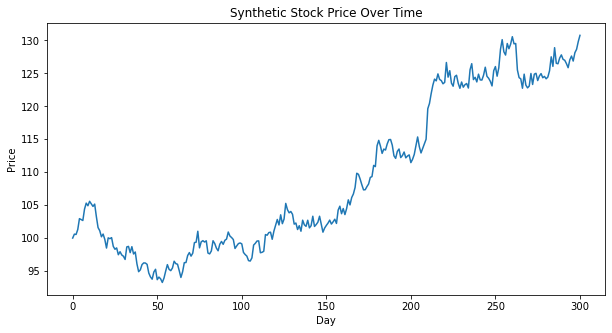

In [27]:
import pandas as pd

def generate_synthetic_stock_data(days=300):
    """
    Generate synthetic stock data using Geometric Brownian Motion.
    To help you get some data to train and evaluate your agents
    """
    np.random.seed(42)  # For reproducibility
    price = 100  # Starting price
    mu = 0.001  # Daily return
    sigma = 0.01  # Daily volatility
    prices = [price]

    for _ in range(days):
        price *= np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
        prices.append(price)

    df = pd.DataFrame({'Close': prices})
    return df

# Generate data
df = generate_synthetic_stock_data(days=300)

# Plot the synthetic stock price
plt.figure(figsize=(10, 5))
plt.plot(df['Close'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Synthetic Stock Price Over Time')
plt.show()


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, random

class StockTradingEnv:
    def __init__(self, df, initial_balance=1000, max_steps=252, window_size=20):
        """
        df: DataFrame containing stock data with 'Close' prices
        initial_balance: Starting capital
        max_steps: Number of trading days in an episode
        window_size: Number of days to calculate moving averages and volatility
        """

        class ObservationSpace(dict):
            def __init__(self, data):
                super().__init__()
                for key, value in data.items():
                    self[key] = value

            @property
            def observation_space(self):
                return dict(self)
            
            @property
            def n(self):
                return len(self.observation_space)
            
        class ActionSpace:
            def __init__(self, data):
                self._space = data

            @property
            def action_space(self):
                return self._space

            @property
            def n(self):
                return len(self.action_space)
            
            def sample(self):
                return random.choice(range(self.n))

        self.stocks = df["Close"]
        self.end = max_steps + window_size
        self.lt = window_size
        self.st = max(math.trunc(window_size/4), 1)
        self.ib = initial_balance
        self.fee = 2 # $2 trading fee per transaction
        self.reset()

        obs = {}
        i = 0
        for p in range(90, 135):
            for s in range(90, 135):
                for l in range(90, 135):
                    for m in range(90-135,135-90):
                        for v in np.arange(0,5,0.1):
                            obs[(p,s,l,m,v)] = i
                            i += 1
        self.observation_space = ObservationSpace(obs)
        self.action_space = ActionSpace([0,1,2]) # hold, buy, sell
    
    def _lta(self, *args):
        d1 = args[0] if args else self.day
        d0 = d1 - self.lt
        return round(np.average(self.stocks[d0:d1]))
    
    def _sta(self, *args):
        d1 = args[0] if args else self.day
        d0 = d1 - self.st
        return round(np.average(self.stocks[d0:d1]))
    
    def _vol(self, *args):
        d1 = args[0] if args else self.day
        d0 = d1 - self.lt
        return round(np.std(self.stocks[d0:d1]), 1)

    def reset(self):
        self.day = self.lt
        self.balance = self.ib
        self.shares = []

    def _get_state(self):
        # (S_p, S_sma, S_lma, S_mom, S_vol)
        price = round(self.stocks[self.day])
        sma = self._sta()
        lma = self._lta()
        mom = sma - lma
        vol = self._vol()
        return self.observation_space[(price, sma, lma, mom, vol)]

    def step(self, action):
        a = {0: "HOLD", 1: "BUY", 2: "SELL"}
        price = self.stocks[self.day]
        reward = 0

        # BUY
        if a[action] == "BUY":
            self.balance -= (price + self.fee)
            self.shares.append(price)
        
        # SELL
        elif a[action] == "SELL":
            self.balance += (price - self.fee)
            self.shares.sort() # sell the "cheapest" share first
            profit = price - self.shares[0] - self.fee
            reward += profit
            self.shares = self.shares[1:]

        # HODL
        new_price = self.stocks[self.day + 1]
        delta = new_price - price
        if a[action] == "HOLD" and delta < 10:
            reward -= 5

        # Termination
        self.day += 1
        if (self.day >= self.end) or (self.balance <= 0):
            done = True

        return self._get_state(), reward, done, {}, {}
    
    def render(self):
        if self.day == self.lt: # plot everything if we're in reset state
            plt.plot(self.stocks)
        else: # otherwise only show prices through simulated "today"
            plt.plot(self.stocks[:self.day])
    
    def plot_performance(self, rewards, actions, balances, inventory_history):
        a = {0: "HOLD", 1: "BUY", 2: "SELL"}

        # List of portfolio entries + state variables for each day
        portfolio = [{
            "capital": self.ib,
            "shares": 0,
            "price": self.stocks[self.lt],
            "lta": self._lta(self.lt),
            "sta": self._sta(self.lt),
            "mom": self._sta(self.lt) - self._lta(self.lt),
            "vol": self._vol(self.lt)
        }]

        # Reconstruct portfolio history
        for i in range(len(actions)):
            day = i + self.lt
            price = self.stocks[day]
            prev_day = portfolio[-1]

            if a[actions[i]] == "BUY":
                capital = prev_day["capital"] - (price + self.fee)
                shares = prev_day["shares"] + 1
            
            elif a[actions[i]] == "SELL":
                capital = prev_day["capital"] + price - self.fee
                shares = prev_day["shares"] - 1
            
            else: # action must be HOLD
                capital = prev_day["capital"]
                shares = prev_day["shares"]
            
            portfolio.append({
                "capital": capital,
                "shares": shares,
                "price": price,
                "lta": self._lta(day),
                "sta": self._sta(day),
                "mom": self._sta(day) - self._lta(day),
                "vol": self._vol(day)
            })
        
        # Construct neat plottable vectors
        value = [day["capital"] + day["shares"]*day["price"] for day in portfolio]
        price = [day["price"] for day in portfolio]
        lta = [day["lta"] for day in portfolio]
        sta = [day["sta"] for day in portfolio]
        mom = [day["mom"] for day in portfolio]
        vol = [day["vol"] for day in portfolio]    

        # Make plots!
        plt.subplots(2,1, sharex=True)
        
        plt.subplot(0)
        plt.plot(value, label="Portfolio Value")
        plt.legend()

        plt.subplot(1)
        plt.plot(price, color="black", label="Price")
        plt.plot(lta, color="tab:green", label="Long-term Avg.")
        plt.plot(sta, color="tab:brown", label="Short-term Avg.")
        plt.plot(mom, color="tab:purple", label="Momentum")
        plt.plot(vol, color="tab:cyan", label="Volatility")
        plt.xlabel("Trading Day")
        plt.legend()
        

## Problem 2b: Agents

In [32]:
env = StockTradingEnv(df)

stock_sarsa = SARSAAgent(env)
sarsa_steps, sarsa_rewards = stock_sarsa.learn(episodes=1000)

: 

In [ ]:
stock_ql = QLearningAgent(env)
ql_steps, ql_rewards = stock_ql.learn(episodes=1000)

In [ ]:
stock_dqn = DQNAgent(env)
dqn_steps, dqn_rewards = stock_dqn.learn(episodes=10)

## Problem 2c: Comparing Policies